In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
from datetime import datetime, timedelta
from func_tools import normalize, get_labels, cnn_data_reshaping, reshape_lob_levels, plot_labels, label_insights, get_pnl

import plotly_express as px
import plotly.figure_factory as ff
import plotly.graph_objects as go
#import tensorflow as tf

In [2]:
security = 'USDT_BTC'
root_caching_folder = "Processed_Data"
frequency = timedelta(seconds=10)
norm_type = 'dyn_z_score'
model_name = 'dynz_score_lob_v3_10s'
trading_fee=0.000712

# labelling inputs
k_plus = 30#60
k_minus = 30#60
alpha = 0.001#0.0005
roll = 7200 * 6 # step from minute to 10 second data

In [3]:
data = pd.read_csv(f'{root_caching_folder}/{security}/data-cache-10s.csv', index_col=0)
lob_depth = data['Level'].max() + 1
train_test_split = int((data.shape[0] / lob_depth) * 0.7) # slice reference for train and test
test_timestamps = data['Datetime'].unique()[train_test_split:] # timestamps array
test_cached_data = data[data['Datetime'].isin(test_timestamps)].set_index(['Datetime', 'Level']) # split

In [4]:
# # Model predictions
# # Load the previously saved weights
# deep_lob_loaded = tf.keras.models.load_model(model_name)

# generator_test = TimeseriesGenerator(
#     test_depth_dyn,
#     encoded_test_labels,
#     100,
#     batch_size=64,
#     shuffle=False
# )

# # Re-evaluate the model
# loss, acc = deep_lob_loaded.evaluate(generator_test, verbose=2)
# print("Restored model, accuracy: {:5.2f}%".format(100*acc))

In [5]:
# import dynamically norm ts - reminder: it's shifted by the rolling window
# import cached dynamic roll normalization - to extract labels
test_dyn_df = pd.read_csv(f'{root_caching_folder}/{security}/TEST-{lob_depth}-{norm_type}-{roll}.csv')

test_dyn_df['Mid_Price'] = (test_dyn_df['Ask_Price'] + test_dyn_df['Bid_Price']) / 2

norm_mid_px = test_dyn_df.reset_index()['Mid_Price']
labels = get_labels(norm_mid_px, k_plus, k_minus, alpha, long_only=False)
# print out labels
label_insights(labels)

Labels shape: (430328,)
Labels: [-1  0  1] 
Count: [212514   8744 209070] 
Pctg: [0.49384191 0.02031938 0.48583871]
Number of total transaction: 13530


13530

In [6]:
# get pnl from normalized labels and real px timeseries (alway postive prices)
roll_shift = (7200*6)+1 # rolling period for dyn z score - + 1 from shift in ft.normalize
top_ob = test_cached_data[test_cached_data.index.get_level_values(1)==0][roll_shift:]
top_ob['Mid_Price'] = (top_ob['Ask_Price'] + top_ob['Bid_Price']) / 2
top_ob['Spread'] = (top_ob['Ask_Price'] - top_ob['Bid_Price']) / top_ob['Mid_Price']
mid_px = top_ob.reset_index()['Mid_Price']

# get pnl dataframe
pnl_simulated, df_simulated, idx_simulated = get_pnl(mid_px, labels, trading_fee=0.000712)

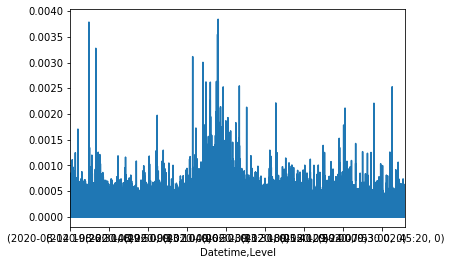

In [7]:
top_ob['Spread'].plot()

In [8]:
# mid px linechart - sampled
hourly_mid_line = go.Figure()
hourly_mid_line.add_trace(go.Scatter(y=mid_px.iloc[::6*60].values, name='mid'))

hourly_mid_line.update_layout(title='<b>Hourly sampled mid</b>')
hourly_mid_line.show()

In [9]:
# isolate one trade - use label changes or idx V
# calculate pnl for that trade - with reinvest or not reinvest
# average length trade V
# percentage of winning trades V
# long and shorts V

# also return bid and ask from get_pnl function V
# sharpe ratio strategy or other useful metrics
# only enter trades with a certain level of certainty (need to use predictions)
# what is the the model confidence to enter trades of 1 period only? Limit those

# costs
# transaction costs: fixed, already included V
# "slippage": incorporate when realistically you would actually enter the trade - 1 period lag Average between current period and next period level V
# spread: you'll likely buy at ask and sell at bid, not at mid V
# slippage: have a size in mind as an input and see how that would work against spread for a certain mkt depth

# plotting
# recap box with main metrics as text
# plot metrics to quickly access risk reward of a strategy
# nicely plot buys and sell together with mid_px line, with hipothetical execution - main chart

# wrap up data fetching, analysis and plotting in a compact workflow, easier to re-execute

# further improvements
# improve with risk management (do not enter a trade unless confortable with risk)
# efficient execution system
# put together a Dash dashboard for this

In [10]:
# test1 = df_simulated[idx_simulated[0]:idx_simulated[1]+1]
# ((test1['px'].values[-1] - test1['px'].values[0])/test1['px'].values[0]) * test1['labels'].values[0]

In [11]:
df_simulated = pd.merge(df_simulated, top_ob.reset_index(), left_index=True, right_index=True)

In [62]:
#idx_simulated_shifted = np.concatenate((0, idx_simulated[1:], np.array([df_simulated.shape[0]])))
start_idx = np.concatenate((np.array([0]), idx_simulated))
end_idx = np.concatenate((idx_simulated, np.array([df_simulated.shape[0]])))
trades = np.array([0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]) # initiate an array with n values - number of columns

def calculate_return(start_px, end_px, trade_type, trading_fee):
    if trade_type == 1:
        pctg_chg = (((end_px - (end_px*trading_fee)) - (start_px+(start_px*trading_fee)))/(start_px)) * trade_type # buy trade
    elif trade_type == -1:
        pctg_chg = (((end_px + (end_px*trading_fee)) - (start_px-(start_px*trading_fee)))/(start_px)) * trade_type # sell trade
    else:
        pctg_chg = 0 # neutral

    return pctg_chg

# loop through each trade
for start_trade, end_trade in zip(start_idx, end_idx):

    try:
        df = df_simulated[start_trade:end_trade] # slice of with single trade
        df_exit_slippage = df_simulated[end_trade+1:end_trade+3]

        trade_type = df['labels'].values[0] # direction from first label

        start_mid_px = df['Mid_Price'].values[0]
        end_mid_px = df['Mid_Price'].values[-1] 

        start_ask_px = df['Ask_Price'].values[0]
        end_ask_px = df['Ask_Price'].values[-1]

        start_bid_px = df['Bid_Price'].values[0]
        end_bid_px = df['Bid_Price'].values[-1]

        if df.shape[0] == 1:
            start_mid_px_slip = df_exit_slippage['Mid_Price'].values[0]
            start_ask_px_slip = df_exit_slippage['Ask_Price'].values[0]
            start_bid_px_slip = df_exit_slippage['Bid_Price'].values[0]

        else:
            start_mid_px_slip = df['Mid_Price'].values[1]
            start_ask_px_slip = df['Ask_Price'].values[1]
            start_bid_px_slip = df['Bid_Price'].values[1]

        end_mid_px_slip_1 = df_exit_slippage['Mid_Price'].values[0] # px at which trade is closed is when new signal is generated
        end_mid_px_slip_2 = df_exit_slippage['Mid_Price'].values[1] # or somewhere between that and the next timestep - time to generate order

        end_ask_px_slip_1 = df_exit_slippage['Ask_Price'].values[0]
        end_ask_px_slip_2 = df_exit_slippage['Ask_Price'].values[1]

        end_bid_px_slip_1 = df_exit_slippage['Bid_Price'].values[0]
        end_bid_px_slip_2 = df_exit_slippage['Bid_Price'].values[1]

        gross_trade_return = calculate_return(start_mid_px, end_mid_px, trade_type, 0) # gross performance
        
        fees_impact = gross_trade_return - calculate_return(start_mid_px, end_mid_px, trade_type, trading_fee) # net trading fee performance (entry and exit)

        slippage_impact = gross_trade_return - calculate_return((start_mid_px + start_mid_px_slip)/2, (end_mid_px_slip_1 + end_mid_px_slip_2)/2, trade_type, 0) # gross minus slippage only using mid

        if trade_type == 1:
            spread_impact = gross_trade_return - calculate_return((start_ask_px + start_ask_px_slip)/2, (end_bid_px_slip_1 + end_bid_px_slip_2)/2, trade_type, 0) - (slippage_impact) # net of bbo spread performance (round-trip)
            net_return = calculate_return((start_ask_px + start_ask_px_slip)/2, (end_bid_px_slip_1 + end_bid_px_slip_2)/2, trade_type, trading_fee) # net return all-in
        elif trade_type == -1:
            spread_impact = gross_trade_return - calculate_return((start_bid_px + start_bid_px_slip)/2, (end_ask_px_slip_1 + end_ask_px_slip_2)/2, trade_type, 0) - (slippage_impact)# net of bbo spread performance (round-trip)
            net_return = calculate_return((start_bid_px + start_bid_px_slip)/2, (end_ask_px_slip_1 + end_ask_px_slip_2)/2, trade_type, trading_fee) # net return all-in
        elif trade_type == 0:
            spread_impact = gross_trade_return # 0
            net_return = gross_trade_return # 0

        array_to_append = np.array([start_trade, 
                                    end_trade, 
                                    start_mid_px, 
                                    start_mid_px_slip, 
                                    end_mid_px,
                                    end_mid_px_slip_1,
                                    end_mid_px_slip_2,
                                    start_ask_px, 
                                    start_ask_px_slip, 
                                    end_ask_px,
                                    end_ask_px_slip_1,
                                    end_ask_px_slip_2,
                                    start_bid_px, 
                                    start_bid_px_slip, 
                                    end_bid_px,
                                    end_bid_px_slip_1,
                                    end_bid_px_slip_2,
                                    trade_type, 
                                    gross_trade_return, 
                                    fees_impact, 
                                    spread_impact, 
                                    slippage_impact, 
                                    net_return])
                                    
        trades = np.vstack([trades, array_to_append])

    except Exception as e:
        print(f'{e} at start_idx = {start_trade} and end_idx = {end_trade}. Shape dataframe = {df_simulated.shape[0]}')
        trades = np.vstack([trades, array_to_append])

index 0 is out of bounds for axis 0 with size 0 at start_idx = 430298 and end_idx = 430328. Shape dataframe = 430328


In [63]:
df_trades_all = pd.DataFrame(trades[1:], 
                            columns=[
                                'start_trade', 
                                'end_trade', 
                                'start_mid_px',
                                'start_mid_px_slip', 
                                'end_mid_px',
                                'end_mid_px_slip_1',
                                'end_mid_px_slip_2',
                                'start_ask_px', 
                                'start_ask_px_slip', 
                                'end_ask_px',
                                'end_ask_px_slip_1',
                                'end_ask_px_slip_2',
                                'start_bid_px', 
                                'start_bid_px_slip',
                                'end_bid_px',
                                'end_bid_px_slip_1',
                                'end_bid_px_slip_2',
                                'direction', 
                                'gross_trade_return', 
                                'fees_impact', 
                                'spread_impact', 
                                'slippage_impact', 
                                'net_return'
                                ])
df_trades_all['trade_length'] = df_trades_all['end_trade'] - df_trades_all['start_trade'] # how many periods a trade lasts
df_trades_all['winning_net_trades'] = df_trades_all.apply(lambda x: 1 if x['net_return']>0 else (-1 if x['net_return']<0 else 0), axis=1) # flag for winning trades
# trades without "zeros" - used to calculate stats
df_trades_in = df_trades_all[df_trades_all['direction'] != 0]
df_trades_in['trade_length'].describe()

count    8581.000000
mean       49.132036
std        38.093278
min         1.000000
25%        24.000000
50%        40.000000
75%        65.000000
max       308.000000
Name: trade_length, dtype: float64

In [74]:
df_trades_in[6:20].T

,10,12,13,14,15,17,18,20,21,23,24,25,26,27
start_trade,338.000000,383.000000,4.290000e+02,460.000000,516.000000,541.000000,633.000000,651.000000,683.000000,794.000000,826.000000,883.000000,988.000000,1018.000000
end_trade,382.000000,429.000000,4.600000e+02,516.000000,540.000000,633.000000,650.000000,683.000000,793.000000,826.000000,883.000000,988.000000,1018.000000,1051.000000
start_mid_px,11765.922626,11777.957458,1.175298e+04,11776.032059,11753.339582,11763.216200,11717.333000,11736.287266,11703.187503,11753.103824,11744.525682,11774.134812,11722.934342,11739.643743
start_mid_px_slip,11765.922626,11777.857211,1.175514e+04,11776.032059,11753.579117,11763.216200,11715.500000,11732.335432,11706.982616,11752.669413,11744.189664,11774.484987,11722.731111,11739.643743
end_mid_px,11776.994862,11752.200067,1.177172e+04,11753.109099,11759.147657,11717.333000,11736.302467,11702.943838,11753.475126,11744.429171,11773.930612,11722.900020,11739.288090,11725.000000
end_mid_px_slip_1,11777.957458,11755.142850,1.177603e+04,11753.579117,11763.216200,11715.500000,11736.287266,11706.982616,11753.103824,11744.189664,11774.484987,11722.731111,11739.643743,11725.000000
end_mid_px_slip_2,11777.857211,11754.492266,1.177603e+04,11754.368276,11763.216200,11716.000000,11732.335432,11710.632100,11752.669413,11744.070568,11774.650210,11722.597128,11734.178205,11721.757174
start_ask_px,11765.922626,11778.603125,1.175298e+04,11776.032059,11754.847355,11763.600000,11717.333000,11736.287266,11704.249618,11754.658395,11747.241186,11774.789145,11724.685501,11740.688347
start_ask_px_slip,11765.922626,11778.402631,1.175514e+04,11776.032059,11755.326426,11763.600000,11716.000000,11733.779174,11706.982616,11753.789573,11746.517527,11774.789145,11724.585501,11740.688347
end_ask_px,11777.311791,11752.979455,1.177182e+04,11754.974055,11759.147657,11717.333000,11736.317328,11705.000000,11755.401000,11747.241186,11774.789145,11724.685501,11740.588347,11725.000000


In [50]:
# #testing
# gross_trade_return = calculate_return(temp_df['start_mid_px'], temp_df['end_mid_px'], temp_df['direction'], 0) # gross performance
# net_fees_return = calculate_return(temp_df['start_mid_px'], temp_df['end_mid_px'], temp_df['direction'], trading_fee) # net trading fee performance (entry and exit)
# net_slippage_return = calculate_return((temp_df['start_mid_px'] + temp_df['start_mid_px_slip'])/2, (temp_df['end_mid_px_slip_1'] + temp_df['end_mid_px_slip_2'])/2, temp_df['direction'], 0) # gross minus slippage only using mid

# gross_trade_return, net_fees_return, net_slippage_return

(0.0018029370434932304, 0.00038022073466805313, 0.0016696227885105999)

In [ ]:
# to do: check if need to add double fees
# check discrepancies between gross and net
# not sure you can just add trading fees subtracting. Cumpounding effects?
# maybe that's behind discrepancies with pnl function?

In [550]:
df_simulated

,px,labels,return,realized_return,trade_flag,pnl,Datetime,Level,Ask_Price,Ask_Size,Bid_Price,Bid_Size,Mid_Price,Spread
0,11799.439763,0,NaN,NaN,False,NaN,2020-08-14 19:26:30,0,11799.439763,2.222219,11799.439763,0.032070,11799.439763,8.474118e-13
1,11803.793449,0,0.000369,0.0,False,1.000000e+00,2020-08-14 19:26:40,0,11808.147136,0.005764,11799.439763,0.033978,11803.793449,7.376758e-04
2,11804.425125,0,0.000054,0.0,False,1.000000e+00,2020-08-14 19:26:50,0,11806.621400,0.000220,11802.228850,0.418870,11804.425125,3.721104e-04
3,11805.533132,0,0.000094,0.0,False,1.000000e+00,2020-08-14 19:27:00,0,11807.556930,2.390975,11803.509334,0.074131,11805.533132,3.428559e-04
4,11806.214667,0,0.000058,0.0,False,1.000000e+00,2020-08-14 19:27:10,0,11808.920000,0.002000,11803.509334,0.079492,11806.214667,4.582897e-04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
430323,10535.661275,0,0.000000,0.0,False,3.628456e+06,2020-10-03 14:59:10,0,10535.661275,2.722016,10535.661275,2.312451,10535.661275,9.492336e-13
430324,10535.661275,0,0.000000,0.0,False,3.628456e+06,2020-10-03 14:59:20,0,10535.661275,2.044618,10535.661275,1.999771,10535.661275,9.492336e-13
430325,10535.661275,0,0.000000,0.0,False,3.628456e+06,2020-10-03 14:59:30,0,10535.661275,2.732419,10535.661275,1.999771,10535.661275,9.492336e-13
430326,10535.661275,0,0.000000,0.0,False,3.628456e+06,2020-10-03 14:59:40,0,10535.661275,2.732419,10535.661275,1.999771,10535.661275,9.492336e-13


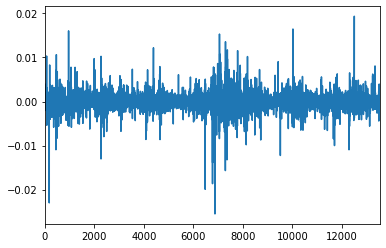

In [327]:
(df_trades_all['pct_chg'] * df_trades_all['direction']).plot()

In [83]:
df_trades_in.head()

,start_trade,end_trade,start_mid_px,start_mid_px_slip,end_mid_px,end_mid_px_slip_1,end_mid_px_slip_2,start_ask_px,start_ask_px_slip,end_ask_px,...,end_bid_px_slip_1,end_bid_px_slip_2,direction,gross_trade_return,fees_impact,spread_impact,slippage_impact,net_return,trade_length,winning_net_trades
1,29.0,53.0,11810.599211,11810.997480,11813.406409,11812.765804,11812.765804,11810.997510,11810.997480,11814.429533,...,11812.283385,11812.283385,1.0,0.000238,0.001424,5.770914e-05,0.000071,-0.001315,24.0,-1
3,54.0,132.0,11812.765804,11812.765804,11791.468131,11792.158483,11793.927400,11813.248224,11813.248224,11794.931431,...,11789.975108,11792.923369,-1.0,0.001803,0.001423,1.756915e-04,0.000133,0.000071,78.0,1
5,133.0,156.0,11792.158483,11793.927400,11808.196587,11808.984455,11808.984455,11794.341858,11794.931431,11808.937300,...,11808.984455,11808.984455,1.0,0.001360,0.001425,1.353037e-04,0.000008,-0.000208,23.0,-1
6,156.0,183.0,11808.937300,11808.984455,11795.695455,11795.695455,11796.430456,11808.937300,11808.984455,11795.695455,...,11795.695455,11796.430456,-1.0,0.001121,0.001423,8.464202e-13,0.000029,-0.000331,27.0,-1
7,183.0,261.0,11795.695455,11795.695455,11816.483438,11816.187906,11816.187921,11795.695455,11795.695455,11817.409161,...,11815.557715,11815.557715,1.0,0.001762,0.001425,5.342613e-05,0.000025,0.000259,78.0,1


In [82]:
# Plot long short trades distributions
hist_trade_length = px.histogram(df_trades_in, x='trade_length', color='direction', title='<b>Trade length</b>')
hist_trade_length.show()

hist_trade_pctg_chg = px.histogram(df_trades_in, x='gross_trade_return', color='direction', title='<b>Trade pctg change</b>')
hist_trade_pctg_chg.show()

hist_trade_pctg_chg = px.histogram(df_trades_in, x='net_return', color='direction', title='<b>Trade pctg change</b>')
hist_trade_pctg_chg.show()
#fig.update_layout(barmode='overlay')

In [88]:
# Percentage of winning trades
pctg_winning_trades = df_trades_in['winning_net_trades'].sum() / df_trades_in.shape[0]

winning_df = df_trades_in[df_trades_in['net_return']>0]
losing_df = df_trades_in[df_trades_in['net_return']<0]

# Average winning trade return
avg_ret_winning = winning_df['net_return'].mean()
w_avg_ret_winning = np.average(winning_df['net_return'], weights=winning_df['trade_length'])

# Average losing trade return
avg_ret_losing = losing_df['net_return'].mean()
w_avg_ret_losing = np.average(losing_df['net_return'], weights=losing_df['trade_length'])

pctg_winning_trades, avg_ret_winning, w_avg_ret_winning, avg_ret_losing, w_avg_ret_losing

(-0.19286796410674747,
 0.001773901986028171,
 0.0023129043468995986,
 -0.0008487851214517466,
 -0.0006668713034871772)

In [85]:
trades_length_grouped = df_trades_all.groupby('direction').agg({'trade_length':['count','mean','sum']})
trades_length_grouped.columns = trades_length_grouped.columns.droplevel(0)
lsn_time_pie = px.pie(trades_length_grouped, values='sum', names=trades_length_grouped.index, title='<b>Long-Short-Neutral (time)</b>')
lsn_time_pie.show()

lsn_numb_trades_sun = px.sunburst(df_trades_all, path=['direction', 'winning_net_trades'],values='trade_length', title='<b>Long-Short-Neutral (# of trades)</b>')
lsn_numb_trades_sun.show()